# Task 2: Hyperelasticity



In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


2024-11-23 22:13:11.907095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 22:13:12.062113: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 22:13:12.100823: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 22:13:12.909869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### Data import

In [2]:
import numpy as np

import tensorflow as tf

def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)

    batch_size = tf.shape(F)[0]
    

    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
 
    I1 = tf.linalg.trace(C)  
    
  
    C_square = tf.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - tf.linalg.trace(C_square))  
    
   
    J = tf.linalg.det(F)  
    

    Gti = tf.constant([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ], dtype=tf.float32)
    

    Gti = tf.tile(Gti[None, :, :], [batch_size, 1, 1])
 
    I4 = tf.linalg.trace(tf.einsum('bij,bjk->bik', C, Gti))  
    

    I3 = tf.linalg.det(C)


    Cof_C = I3[:, None, None] * tf.linalg.inv(C)


    I5 = tf.linalg.trace(tf.einsum('bij,bjk->bik', Cof_C, Gti)) 
    
    return I1, J, I4, I5

In [3]:
data_biaxial = np.loadtxt('../../calibration/biaxial.txt')
data_pure_shear = np.loadtxt('../../calibration/pure_shear.txt')
data_uniaxial = np.loadtxt('../../calibration/uniaxial.txt')


def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    W = data[:, 18] 
    return F, P, W


F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_pure_shear, P_pure_shear, W_pure_shear = process_data(data_pure_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

In [4]:

I1_data_biaxial,J_data_biaxial,I4_data_biaxial,I5_data_biaxial = compute_invariants(F_biaxial) 
I1_data_pure_shear,J_data_pure_shear,I4_data_pure_shear,I5_data_pure_shear = compute_invariants(F_pure_shear)
I1_data_uniaxial,J_data_uniaxial,I4_data_uniaxial,I5_data_uniaxial = compute_invariants(F_uniaxial)

2024-11-23 22:13:14.259462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 22:13:14.518741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 671 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-11-23 22:13:14.600534: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x706f520


In [5]:
data_biaxial_test = np.loadtxt('../../test/biax_test.txt')
data_mixed_test = np.loadtxt('../../test/mixed_test.txt')

F_mixed_test, P_mixed_test, W_mixed_test = process_data(data_mixed_test)
F_biaxial_test, P_biaxial_test, W_biaxial_test = process_data(data_biaxial_test)
I1_data_biaxial_test,J_data_biaxial_test,I4_data_biaxial_test,I5_data_biaxial_test = compute_invariants(F_biaxial_test)
I1_data_mixed_test,J_data_mixed_test,I4_data_mixed_test,I5_data_mixed_test = compute_invariants(F_mixed_test)

In [6]:
import numpy as np


I_train_biaxial = np.column_stack((I1_data_biaxial, J_data_biaxial, -J_data_biaxial, I4_data_biaxial, I5_data_biaxial))
I_train_pure_shear = np.column_stack((I1_data_pure_shear, J_data_pure_shear, -J_data_pure_shear, I4_data_pure_shear, I5_data_pure_shear))
I_train_uniaxial = np.column_stack((I1_data_uniaxial, J_data_uniaxial, -J_data_uniaxial, I4_data_uniaxial, I5_data_uniaxial))

I_train = np.concatenate([I_train_biaxial, I_train_pure_shear, I_train_uniaxial], axis=0)


I_test_biaxial = np.column_stack((I1_data_biaxial_test, J_data_biaxial_test, -J_data_biaxial_test, I4_data_biaxial_test, I5_data_biaxial_test))
I_test_mixed = np.column_stack((I1_data_mixed_test, J_data_mixed_test, -J_data_mixed_test, I4_data_mixed_test, I5_data_mixed_test))


I_test = np.concatenate([I_test_mixed, I_test_biaxial], axis=0)


In [7]:
W_train = np.concatenate([W_biaxial, W_pure_shear, W_uniaxial], axis=0)

In [8]:
I_train_tensor = tf.convert_to_tensor(I_train, dtype=tf.float32)
W_train_tensor = tf.convert_to_tensor(W_train, dtype=tf.float32)
I_test_tensor = tf.convert_to_tensor(I_test, dtype=tf.float32)

### Load model

In [9]:

import models as lm
importlib.reload(lm)
model1 = lm.main()

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 private_c_to_w (_C_to_W)    (None, 1)                 385       
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
21/21 [==============================] - 0s 2ms/step - loss: 514.2082
Epoch 2/2500
21/21 [==============================] - 0s 1ms/step - loss: 443.6452
Epoch 3/2500
21/21 [==============================] - 0s 1ms/step - loss: 366.7404
Epoch 4/2500
21/21 [==============================] - 0s 1ms/step - loss: 297.3907
Epoch 5/2500
21/21 [==============================] - 0s 1ms/step - loss: 256.1540
Epoch 6/2500
21/21 [==============================] - 0s 1ms/step - loss: 240.3763
Epoch 7/2500
21/21 [==============================] - 0s 1ms/step - loss: 233.1165
Epoch 8/2500
21/21 [==============================] - 0s 1ms/step - loss: 226.9489
Epoch 9/2500
21/21 [==============================] - 0s 1ms/step - loss: 220.8004
Epoch 10/2500
21/21 [==============================] - 0s 1ms/step - loss: 215.9791
Epoch 11/2500
21/21 [==============================] - 0s 2ms/step - loss: 210.3844
Epoch 12/2500
21/21 [==============================] - 0s 1ms/step - loss: 205.9044
E

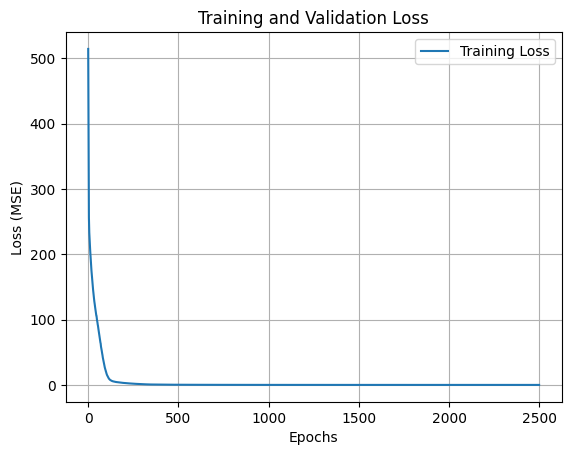

In [10]:


history = model1.fit(I_train_tensor, W_train_tensor, epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [11]:
def compute_stress_tensor(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)

  
    P = tape.gradient(W_pred, F)
    
 
    #print("P:", P)
    
    return P

In [12]:
P_biaxial_test_pred = compute_stress_tensor(F_biaxial_test,model1)
P_mixed_test_pred = compute_stress_tensor(F_mixed_test, model1)
P_biaxial_pred = compute_stress_tensor(F_biaxial, model1)
P_pure_shear_pred = compute_stress_tensor(F_pure_shear, model1)
P_uniaxial_pred = compute_stress_tensor(F_uniaxial, model1)

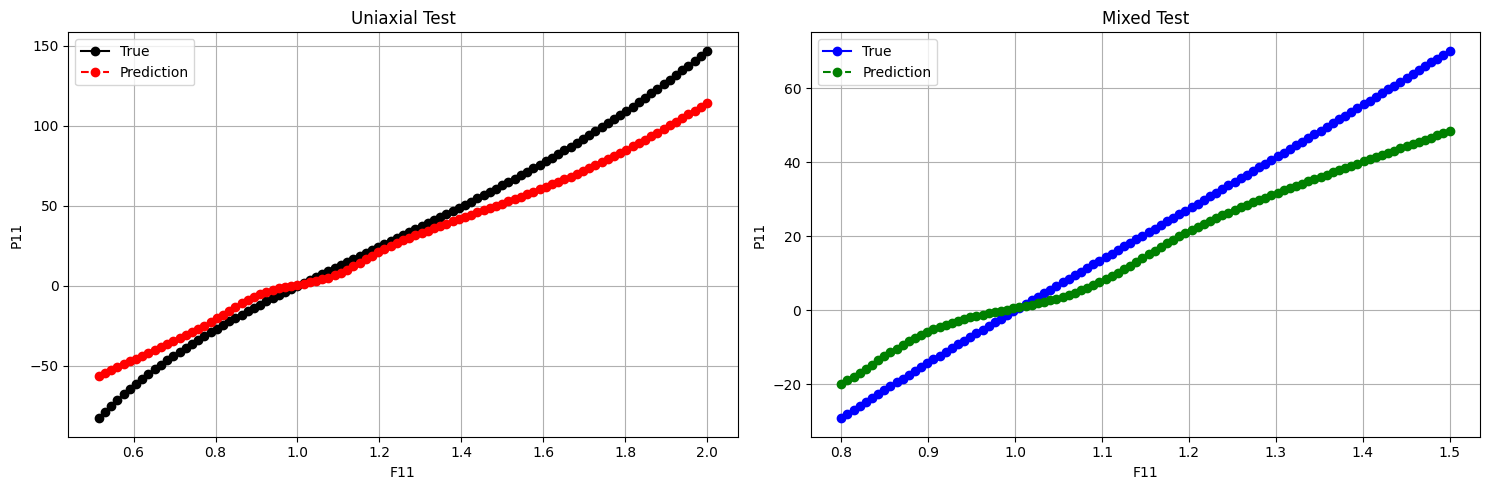

In [13]:

def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0, 0]


    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

   
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

   
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    
    plt.tight_layout()
    plt.show()


plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)

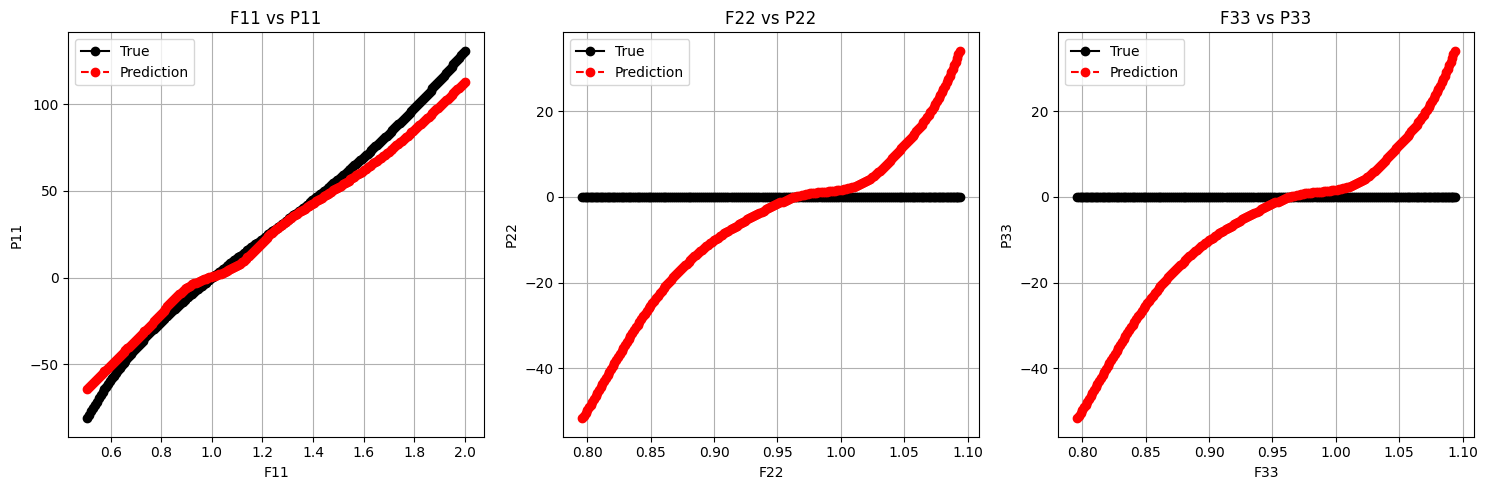

In [14]:
def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    
    F11 = F_uniaxial[:, 0, 0]  
    F22 = F_uniaxial[:, 1, 1] 
    F33 = F_uniaxial[:, 2, 2] 

    P11 = P_uniaxial[:, 0, 0]  
    P22 = P_uniaxial[:, 1, 1]  
    P33 = P_uniaxial[:, 2, 2]  

    P11_pred = P_uniaxial_pred[:, 0, 0]  
    P22_pred = P_uniaxial_pred[:, 1, 1]  
    P33_pred = P_uniaxial_pred[:, 2, 2]  

    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    
    plt.tight_layout()
    plt.show()


plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


### Calibrate the model using both

In [15]:
model2 = model1
optimizer = tf.optimizers.Adam(learning_rate=0.001)


def train_step(F, P_true, model):
    with tf.GradientTape(persistent=True) as tape:  
        tape.watch(F)
        
        
        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)
        
        
        P_pred = tape.gradient(W_pred, F)
        
        
        loss_P = tf.reduce_mean(tf.square(P_pred - P_true))  
        loss = loss_P
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [16]:
F_train = np.concatenate([F_biaxial, F_pure_shear, F_uniaxial], axis=0)
F_train_tensor = tf.convert_to_tensor(F_train, dtype=tf.float32)
P_train = np.concatenate([P_biaxial, P_pure_shear, P_uniaxial], axis=0)
P_train_tensor = tf.convert_to_tensor(P_train, dtype=tf.float32)

In [17]:
for epoch in range(2500):
   
    loss = train_step(F_train_tensor, P_train_tensor, model2)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 251.9257049560547
Epoch 2, Loss: 247.68960571289062
Epoch 3, Loss: 243.57289123535156
Epoch 4, Loss: 239.57546997070312
Epoch 5, Loss: 235.69740295410156
Epoch 6, Loss: 231.9385223388672
Epoch 7, Loss: 228.29830932617188
Epoch 8, Loss: 224.77622985839844
Epoch 9, Loss: 221.37149047851562
Epoch 10, Loss: 218.08319091796875
Epoch 11, Loss: 214.91012573242188
Epoch 12, Loss: 211.85093688964844
Epoch 13, Loss: 208.90386962890625
Epoch 14, Loss: 206.0670623779297
Epoch 15, Loss: 203.33836364746094
Epoch 16, Loss: 200.71536254882812
Epoch 17, Loss: 198.19857788085938
Epoch 18, Loss: 195.7821044921875
Epoch 19, Loss: 193.4627227783203
Epoch 20, Loss: 191.23756408691406
Epoch 21, Loss: 189.1089324951172
Epoch 22, Loss: 187.06781005859375
Epoch 23, Loss: 185.11068725585938
Epoch 24, Loss: 183.23416137695312
Epoch 25, Loss: 181.43490600585938
Epoch 26, Loss: 179.7095184326172
Epoch 27, Loss: 178.0546417236328
Epoch 28, Loss: 176.46688842773438
Epoch 29, Loss: 174.94285583496094
Ep

In [18]:
P_biaxial_test_pred = compute_stress_tensor(F_biaxial_test,model2)
P_mixed_test_pred = compute_stress_tensor(F_mixed_test, model2)
P_biaxial_pred = compute_stress_tensor(F_biaxial, model2)
P_pure_shear_pred = compute_stress_tensor(F_pure_shear, model2)
P_uniaxial_pred = compute_stress_tensor(F_uniaxial, model2)

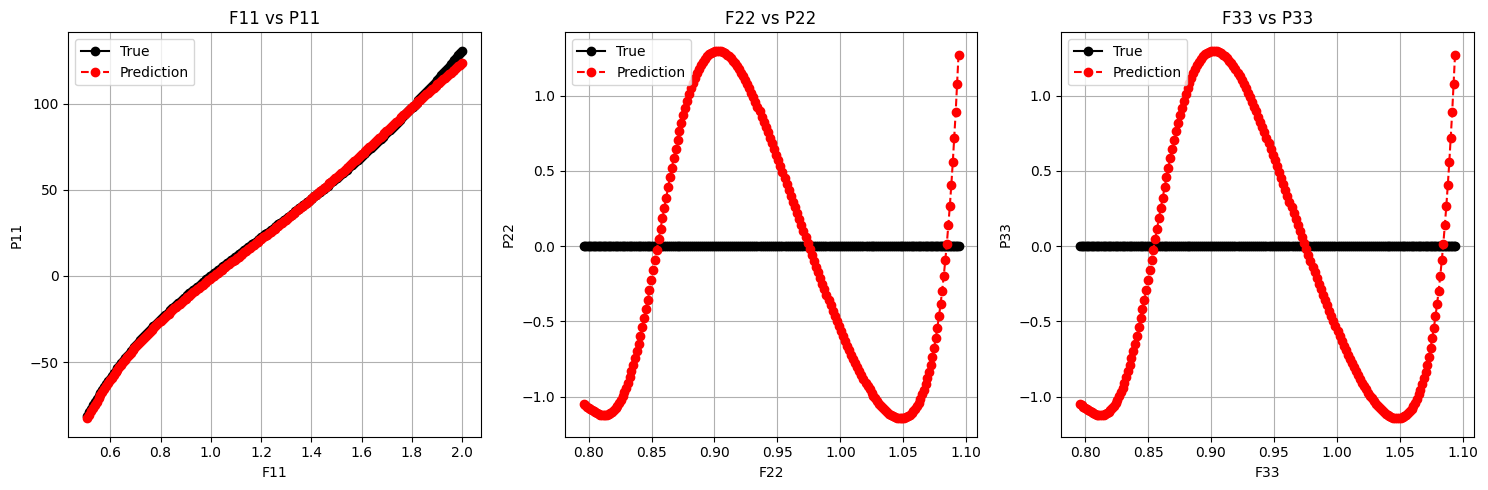

In [19]:
def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):

    F11 = F_uniaxial[:, 0, 0]  
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] 

    P11 = P_uniaxial[:, 0, 0]  
    P22 = P_uniaxial[:, 1, 1]  
    P33 = P_uniaxial[:, 2, 2]  

    P11_pred = P_uniaxial_pred[:, 0, 0] 
    P22_pred = P_uniaxial_pred[:, 1, 1] 
    P33_pred = P_uniaxial_pred[:, 2, 2] 


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

  
    plt.tight_layout()
    plt.show()


plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


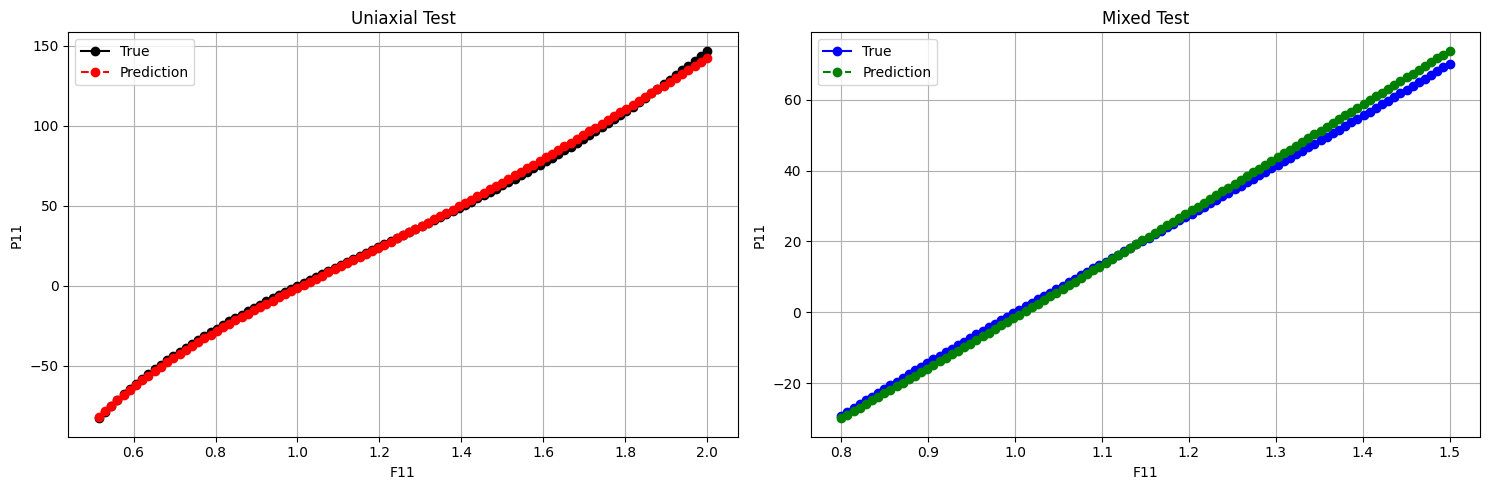

In [20]:
import matplotlib.pyplot as plt


def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0, 0]



    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)


    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)


    plt.tight_layout()
    plt.show()


plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)
